# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

## Import thư viện cần thiết

In [7]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.svg
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.static_evaluation import evaluate_board


## Config đường dẫn

In [8]:
stockfish_path = "./stockfish"
# stockfish_path = ".venv/Scripts/stockfish.exe"

## Stockfish Engine

In [9]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(20)
stockfish.set_depth(20)

In [10]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"] if score["type"] == "cp" else (1000 if score["value"] > 0 else -1000)

## Lấy tập dữ liệu

In [11]:
df = pd.read_csv('chessData.csv')
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [12]:
test_fens = df.sample(n=100, random_state=10)['FEN'].to_list()
stockfish_scores = (
    df.sample(n=100, random_state=10)['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)  # Remove "+"
    .str.extract(r'([-]?\d+)')[0]       # Extract numbers (returns DataFrame, select column 0)
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()  # Convert to Python list
)

print(stockfish_scores)
print(sum(stockfish_scores))

[-459, 28, -50, 695, 130, 41, 0, -865, -89, -329, -66, -374, 103, 119, 13, 539, 0, 68, 393, -223, 0, 129, 0, 81, -202, 762, 146, -95, 0, 201, -117, -174, 62, 103, -392, 0, 13, -175, 202, -42, -130, 276, 253, -14, -8, 0, 663, 192, 64, -13, 96, 0, -68, 0, 3, -442, 277, -2, -206, 157, -35, -889, -68, -164, 0, -37, 221, -104, -10, -92, 153, -130, 56, 123, 373, 92, -1039, -5997, 175, -389, 80, 119, 414, -235, 38, -343, -22, 210, -24, 109, -939, -13, 13, -16, 114, -112, -56, -49, -82, -116]
-7397


## Visualization

In [13]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [14]:
showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

# 1. Initialization

In [15]:
import numpy as np

def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    # Define bounds for each gene type
    bounds = np.array([
        [-5, 5],    # Evaluation Weight: Material (float)
        [-5, 5],    # Evaluation Weight: King Safety (float)
        [-5, 5],    # Evaluation Weight: Pawn Structure (float)
        [-5, 5],    # Evaluation Weight: Mobility (float)
        [-5, 5],    # Evaluation Weight: Center Control (float)
        [-5, 5],    # Evaluation Weight: Piece Square (float)
        [-5, 5],    # Evaluation Weight: Tactical Position (float)
        [-5, 5],    # Evaluation Weight: Tempo (float)
        [80, 120],   # Pawn Value (int)
        [270, 350],  # Knight Value (int)
        [300, 350],  # Bishop Value (int)
        [450, 550],  # Rook Value (int)
        [850, 1050], # Queen Value (int)
        [9000, 12000], # King Value (int)
        [0, 30],  # Doubled Pawn Penalty (int)
        [0, 30],  # Isolated Pawn Penalty (int)
        [0, 50],   # King Safety Multiplier (int)
        [0, 10],   # Mobility Multiplier (int)
        [0, 20],    # Center Control Multiplier (int)
        [0, 20],    # Piece-Square Table (int)
        [0, 20],    # Evaluation of Pieces (int)
        [0, 20]     # Tempo (int)
    ], dtype=float)  # Ensure correct handling of float vs int

    num_params = len(bounds)

    # Vectorized population initialization
    population = np.zeros((size, num_params))

    # Generate floating-point parameters for the first 8 bounds
    float_indices = np.arange(8)
    population[:, float_indices] = np.random.uniform(bounds[float_indices, 0], bounds[float_indices, 1], size=(size, len(float_indices)))

    # Generate integer parameters for the remaining bounds
    int_indices = np.arange(8, num_params)
    population[:, int_indices] = np.random.randint(bounds[int_indices, 0], bounds[int_indices, 1] + 1, size=(size, len(int_indices)))

    return population

# Generate population with 200 individuals
population = initialize_population(200)

# Print first 3 individuals for verification
print(population[:3])


[[ 2.32693790e+00  2.17635717e+00  2.73412022e+00 -4.61429911e-01
  -2.57406727e+00  4.98386211e+00 -4.88686187e+00  1.36494874e+00
   1.20000000e+02  2.71000000e+02  3.49000000e+02  4.59000000e+02
   8.96000000e+02  1.00240000e+04  1.80000000e+01  1.30000000e+01
   9.00000000e+00  6.00000000e+00  2.00000000e+01  0.00000000e+00
   3.00000000e+00  1.30000000e+01]
 [-9.23844803e-01 -2.45372571e+00  3.22667458e+00  2.46562788e+00
  -2.32783079e+00  3.20015136e+00  1.02319060e+00  2.49422412e+00
   1.06000000e+02  3.21000000e+02  3.31000000e+02  4.93000000e+02
   9.58000000e+02  1.14460000e+04  1.20000000e+01  1.00000000e+00
   4.60000000e+01  2.00000000e+00  1.10000000e+01  2.00000000e+01
   1.50000000e+01  1.20000000e+01]
 [-6.95816859e-01 -2.61202279e+00 -4.03132193e+00 -8.73295944e-01
  -2.54291056e+00  9.50378961e-01  4.20058387e+00 -1.33094353e+00
   1.07000000e+02  2.84000000e+02  3.03000000e+02  4.66000000e+02
   9.37000000e+02  9.14500000e+03  1.00000000e+01  2.80000000e+01
   4.3

# Fitness function

In [16]:
def fitness_function(weights: List[float]) -> float:
    total_error = 0
    for fen, sf_score in zip(test_fens, stockfish_scores):
        eval_score = evaluate_board(fen, weights)
        total_error += (eval_score - sf_score) ** 2
    return -total_error / len(test_fens) # Càng gần giá trị của Stockfish thì fitness càng cao

# Selection

In [17]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [18]:
import numpy as np

def sbx_crossover_single(parent1_value, parent2_value, eta=1.0):
    """
    Perform Simulated Binary Crossover (SBX) on a single continuous value.
    
    Args:
        parent1_value (float): First parent value.
        parent2_value (float): Second parent value.
        eta (float): Distribution index for SBX.
    
    Returns:
        float: Child value generated from SBX.
    """
    if abs(parent1_value - parent2_value) > 1e-6:
        # Ensure parent1_value is always the smaller one
        if parent1_value > parent2_value:
            parent1_value, parent2_value = parent2_value, parent1_value
        
        delta = parent2_value - parent1_value
        beta = 1.0 + 2.0 * delta / (parent2_value - parent1_value)
        alpha = 2.0 - beta ** -(eta + 1)
        return 0.5 * ((1 + alpha) * parent1_value + (1 - alpha) * parent2_value)
    else:
        # No crossover if the values are very close, just inherit
        return np.random.choice([parent1_value, parent2_value])

def uniform_crossover_integer(parent1_value, parent2_value):
    """
    Perform uniform crossover for a single integer value.
    
    Args:
        parent1_value (int): First parent value.
        parent2_value (int): Second parent value.
    
    Returns:
        int: Child value selected from one of the parents.
    """
    return np.random.choice([parent1_value, parent2_value])

def crossover_mixed(parent1, parent2, crossover_rate=0.7):
    """
    Perform mixed crossover (SBX for continuous and uniform for integer genes).
    
    Args:
        parent1 (np.array): First parent (continuous and integer genes).
        parent2 (np.array): Second parent (continuous and integer genes).
        crossover_rate (float): Probability of crossover for each gene.
    
    Returns:
        np.array: Child individual generated from crossover.
    """
    child = np.zeros_like(parent1)
    
    for i in range(len(parent1)):
        if np.random.rand() < crossover_rate:  # Apply crossover with the given probability
            if i < 8:  # Continuous genes (evaluation weights)
                child[i] = sbx_crossover_single(parent1[i], parent2[i])
            else:  # Integer genes (piece values, penalties)
                child[i] = uniform_crossover_integer(parent1[i], parent2[i])
        else:
            child[i] = np.random.choice([parent1[i], parent2[i]])  # Inherit directly from a parent
    
    return child

# Mutation

In [19]:
def mutate_mixed(individual, mutation_rate=0.6, mutation_strength=0.1):
    """
    Apply adaptive mutation to floating-point and integer genes.

    Args:
        individual (np.array): Individual's genes.
        mutation_rate (float): Probability of mutation.
        mutation_strength (float): Mutation intensity.

    Returns:
        np.array: Mutated individual.
    """
    mutated = np.copy(individual)

    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Mutation occurs with probability
            if i < 8:  # Floating-point mutation (evaluation weights)
                mutated[i] += np.random.normal(-mutation_strength, mutation_strength)
            else:  # Integer mutation (piece values, penalties, multipliers)
                step = np.random.randint(-1, 2)  # Change by -1, 0, or +1
                mutated[i] += step

    return mutated


In [ ]:
def adaptive_crossover_rate(best_fitness_score, previous_fitness, crossover_rate, thresh=0.01, min_rate=0.2, max_rate=0.7, adjustment_factor=0.05):
    """
    Adaptive crossover rate: 
        - If fitness improves, reduce the crossover rate (focusing on exploitation).
        - If fitness stagnates, increase the crossover rate (focusing on exploration).
        - If fitness change is no more than `thresh%`, randomize the crossover rate.
    
    Args:
        best_fitness_score (float): The best fitness score of the current population.
        previous_fitness (float): The best fitness from the previous generation.
        crossover_rate (float): The current crossover rate.
        thresh (float): The threshold for percentage change in fitness to trigger random crossover rate adjustment.
        min_rate (float): The minimum allowed crossover rate.
        max_rate (float): The maximum allowed crossover rate.
        adjustment_factor (float): The factor by which the crossover rate is adjusted when fitness improves or stagnates.

    Returns:
        float: The adjusted crossover rate.
    """
    # Calculate the percentage change in fitness
    fitness_change = abs(best_fitness_score - previous_fitness) / abs(previous_fitness)

    # Print the percentage change in fitness
    print(f"Fitness change: {fitness_change * 100:.2f}%")

    # If the fitness change is less than or equal to the threshold, randomize the crossover rate
    if fitness_change <= thresh:
        crossover_rate = random.uniform(min_rate, max_rate)
        print(f"Fitness change is below threshold, randomizing crossover rate: {crossover_rate:.2f}")

    return crossover_rate


In [ ]:
import numpy as np
import random

def adaptive_mutation_rate(fitness_score, previous_fitness, mutation_rate, thresh=0.01, min_rate=0.1, max_rate=0.4):
    """
    Adaptive mutation rate: 
        - If fitness improves, reduce the mutation rate (exploitation).
        - If fitness stagnates, increase the mutation rate (exploration).
        - If fitness change is no more than `thresh%`, randomize the mutation rate.
    
    Args:
        fitness_scores (np.array): The fitness scores of the current population.
        previous_fitness (float): The best fitness from the previous generation.
        mutation_rate (float): The current mutation rate.
        thresh (float): The threshold for percentage change in fitness to trigger random mutation rate adjustment.
        min_rate (float): The minimum allowed mutation rate.
        max_rate (float): The maximum allowed mutation rate.

    Returns:
        float: The adjusted mutation rate.
    """
    # Calculate the percentage change in fitness
    fitness_change = abs(fitness_score - previous_fitness) / abs(previous_fitness)

    # Print the percentage change in fitness
    print(f"Fitness change: {fitness_change * 100:.2f}%")

    # If the fitness change is less than or equal to the threshold, randomize the mutation rate
    if fitness_change <= thresh:  # Convert threshold to percentage
        mutation_rate = random.uniform(min_rate, max_rate)

    return mutation_rate


# GA

In [ ]:
def genetic_algorithm(
    fitness_function,
    population_size=100,
    generations=100,
    elite_size=10,
    tournament_size=5,
    convergence_threshold=20
):
    """
    Runs an optimized Genetic Algorithm with adaptive mutation and crossover rates.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals retained.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if no improvement.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf
    no_improvement_count = 0
    mutation_rate = 0.3
    crossover_rate = 0.4

    for generation in range(generations):
        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])
        
        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)
        
        # Adaptive rates
        mutation_rate = adaptive_mutation_rate(current_best_fitness, best_fitness, mutation_rate)
        crossover_rate = adaptive_crossover_rate(current_best_fitness, best_fitness, crossover_rate)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Stop early if fitness has not improved
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_mixed(p1, p2, crossover_rate)
            child = mutate_mixed(child, mutation_rate, mutation_strength=0.1)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}, Mutation Rate = {mutation_rate:.3f}, Crossover Rate = {crossover_rate:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -632679.939, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 2: Best Fitness = -547553.198, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 3: Best Fitness = -484894.151, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 4: Best Fitness = -451272.239, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 5: Best Fitness = -451272.239, Mutation Rate = 0.350, Crossover Rate = 0.550
Generation 6: Best Fitness = -396928.050, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 7: Best Fitness = -378030.434, Mutation Rate = 0.250, Crossover Rate = 0.450
Generation 8: Best Fitness = -378030.434, Mutation Rate = 0.350, Crossover Rate = 0.550
Generation 9: Best Fitness = -378030.434, Mutation Rate = 0.350, Crossover Rate = 0.550
Generation 10: Best Fitness = -378030.434, Mutation Rate = 0.350, Crossover Rate = 0.550
Generation 11: Best Fitness = -378030.434, Mutation Rate = 0.350, Crossover Rate = 0.550
✅ Converged after 12 generatio

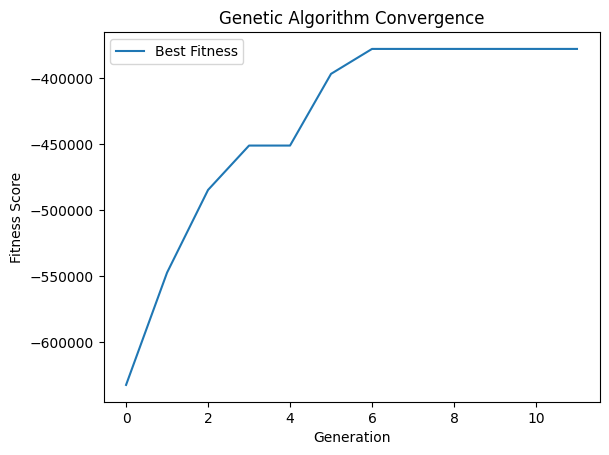

Optimized Weights: [ 1.15682822e+00 -9.06238709e+00  2.68518803e+00  3.63227827e-02
 -2.26868996e+00 -1.22492909e-01  2.18491092e-01 -4.83270976e+00
  1.10000000e+02  2.77000000e+02  3.24000000e+02  4.77000000e+02
  9.74000000e+02  9.53100000e+03  9.00000000e+00  2.10000000e+01
  2.00000000e+00  3.00000000e+00  5.00000000e+00  1.90000000e+01
  7.00000000e+00  1.40000000e+01]
Suggested weights fitness: -458456.4887828126


In [26]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=100, generations=200, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15, 1.05, 0.85, -0.95, # trọng số tối ưu từng hàm 
                100, 300, 320, 500, 900, 10000, # giá trị từng quân cờ trong bàn cờ - cố định
                10, 10, # pawn_structure
                20, # king_safety
                5,# mobility
                10, # centrer_control
                13, # piece-square table
                15, # eva piece
                13 # tempo
            ]
print("Suggested weights fitness:", fitness_function(chromosomes))